# We will cover these topics-

1. Generative Adversarial Networks (GANs)
2. Deep Convolutional GAN (DCGAN)
3. Hasing using Binary AutoEncoder
4. Denoising AutoEncoder (3 Channel Image)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# 1. Generative Adversarial Networks (GANs)

In [4]:
#--------------------------
# lets load mnist dataset |
#--------------------------
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [5]:
cls()

coding_size = 10 # Latent representation

# Generator will take latent/coding just like decoders
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(28*28, activation='sigmoid'), # To get 0-1 output at pixel level
    tf.keras.layers.Reshape([28,28])
])

# Simple classifier predict fake or real
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(30, activation='elu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
gan = tf.keras.Sequential([generator, discriminator])

In [6]:
# Used to train discriminator
discriminator.compile(loss='binary_crossentropy',optimizer='adam')

# used to train generator only. As discriminators param freeze
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [7]:
# Lets prepare some dataset
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1_000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


In [8]:
# GAN will train into 2 phases;
# Phase-1: During phase one, Discriminator will train to 
# classify fake or real image on passing X real or X fake 
# gaussian noise image.
# Note: Param of generator will freeze in this phase.
# Phase-2: Generator will train on gaussian noise image
# and output is pass to discriminator as an true image
# Note: params of discriminator freeze in this phase.

# To train this we have to create custom training loop
# fit() will take input and epochs, will train_on_batch()
# will take only input to train.

In [28]:
# Used to plot multiple image
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [37]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs):
    # Two sequential layers
    generator, discriminator = gan.layers
    for epochs in range(n_epochs):
        print(f"Epoch {epochs+1}/{n_epochs}")
        for x_batch in dataset:
            # Phase-1: Train discriminator only
            noise = tf.random.normal([batch_size, coding_size])
            generated_images = generator(noise) # batch x 28 x 28
            x_fake_n_real = tf.concat([generated_images, x_batch], axis=0) # Appending images
            y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_n_real, y1)

            # Phase-2: Train generator only
            y2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images.numpy()[:16], 8)
        plt.show()

Epoch 1/4


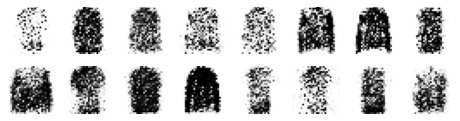

Epoch 2/4


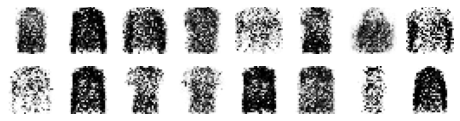

Epoch 3/4


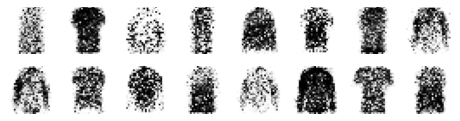

Epoch 4/4


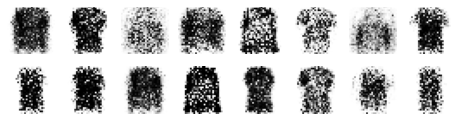

In [38]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs=4)

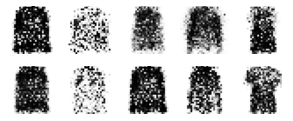

In [40]:
# Lets generate some fake images
cls()
codings = tf.random.normal([10,coding_size])
plot_multiple_images(generator(codings),5)

# 2. Deep Convolutional GAN (DCGAN)

In [58]:
cls()

coding_size = 10

# In generator we expand the image so we use deconvolution
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*30,input_shape=[coding_size]),
    tf.keras.layers.Reshape([7,7,30]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(10,kernel_size=5,strides=2,padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1,kernel_size=5,strides=2,padding="same", activation="tanh"),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8,kernel_size=5,strides=2,padding="same",activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(16, kernel_size=5, strides=2, padding="same",activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         24091     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4209      
                                                                 
Total params: 28,300
Trainable params: 28,220
Non-trainable params: 80
_________________________________________________________________


In [60]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [61]:
# Generator will generate then image [batch, nrow, ncol, 1] one feature map
# so we need to reshape our input data as well 
# because will training discriminator will concat generated & real images
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale
X_train_dcgan.shape

(55000, 28, 28, 1)

Epoch 1/5


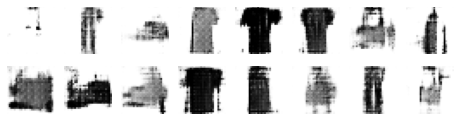

Epoch 2/5


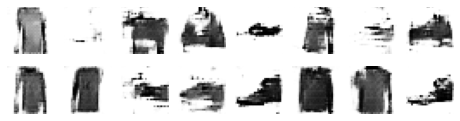

Epoch 3/5


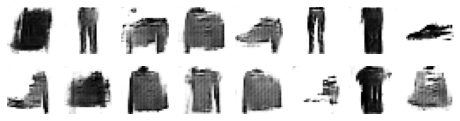

Epoch 4/5


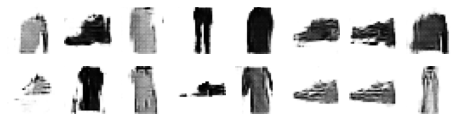

Epoch 5/5


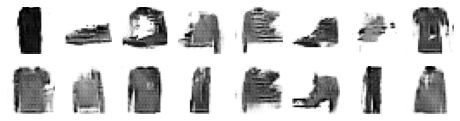

In [62]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, coding_size, n_epochs=5)

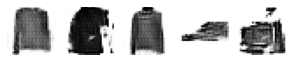

In [75]:
noise = tf.random.normal(shape=[5, coding_size])
plot_multiple_images(generator(noise).numpy(),5)

# 3. Hashing using a Binary AutoEncoder

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [82]:
cls()

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])

hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
hashing_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 16)                40066     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            40834     
                                                                 
Total params: 80,900
Trainable params: 80,900
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = hashing_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0566 - val_loss: 0.0578
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0444 - val_loss: 0.0519
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0408 - val_loss: 0.0470
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0385 - val_loss: 0.0429
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0371 - val_loss: 0.0411


In [88]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


def plot_reconstructions_fake(model, shape, normal=False):
    input = tf.random.uniform(shape,0,1)
    if normal:
        input = tf.random.normal(shape)
    n_images = input.shape[0]
    reconstructions = np.clip(model(input), 0, 1)
    fig = plt.figure(figsize=(n_images * 2, 5))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
    plt.show()        

1/1 [==============================] - 0s 73ms/step


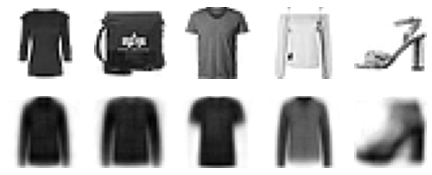

In [87]:
plot_reconstructions(hashing_ae)

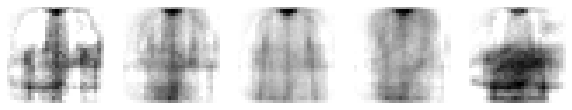

In [90]:
plot_reconstructions_fake(hashing_decoder,(5,16))

Now let's see what the hashes look like for the first few images in the validation set:

In [99]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

157/157 [==============================] - 0s 1ms/step
1110101111000111
1010001111000111
1110001111100111
1010101111000110
1011011101001011
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

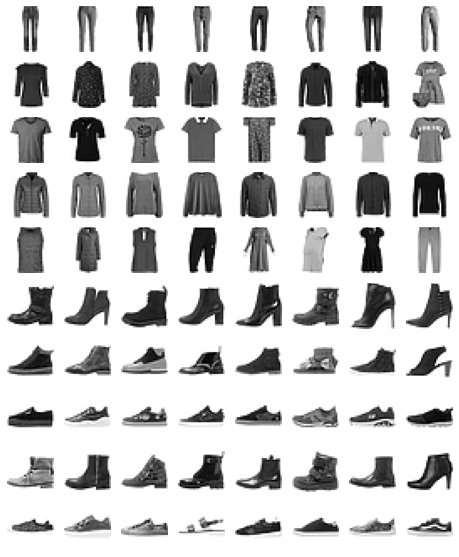

In [100]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()

# 4. Conv2D Denoising AutoEncoder (3 Channel Image)

In [105]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

170498071/170498071 [==============================] - 601s 4us/step


In [108]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [111]:
cls()

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1, input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(12, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
])

denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding="same", activation="sigmoid")
])

denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam",metrics=["mse"])
denoising_ae.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                197008    
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         533347    
                                                                 
Total params: 730,355
Trainable params: 730,355
Non-trainable params: 0
_________________________________________________________________


In [112]:
history = denoising_ae.fit(X_train, X_train, epochs=5, validation_data=(X_test, X_test))

Epoch 1/5
1563/1563 [==============================] - 41s 25ms/step - loss: 0.6018 - mse: 0.0221 - val_loss: 0.6013 - val_mse: 0.0212
Epoch 2/5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.5851 - mse: 0.0150 - val_loss: 0.5870 - val_mse: 0.0153
Epoch 3/5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.5817 - mse: 0.0137 - val_loss: 0.5909 - val_mse: 0.0170
Epoch 4/5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.5797 - mse: 0.0130 - val_loss: 0.5861 - val_mse: 0.0150
Epoch 5/5
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5788 - mse: 0.0126 - val_loss: 0.5819 - val_mse: 0.0135


1/1 [==============================] - 0s 74ms/step


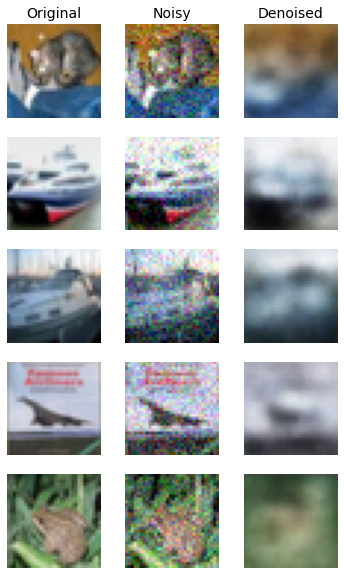

In [113]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()